<a href="https://colab.research.google.com/github/harimshin/data-science-portfolio/blob/main/Time_Series_Analysis_(SARIMA_vs_Facebook_Prophet)_Super_Store_Sales_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%%bash
pip install plotly
pip install prophet

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import itertools
import math

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go

import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error

from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error

from scipy.optimize import minimize
import statsmodels.tsa.api as smt
import statsmodels.api as sm

from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.sm_exceptions import warnings

from prophet import Prophet

from orbit.models import LGT
from orbit.diagnostics.plot import plot_predicted_data
from orbit.diagnostics.plot import plot_predicted_components

In [ ]:
url = 'https://media.githubusercontent.com/media/harimshin/public_dataset/main/superstore_sales.csv'
data = pd.read_csv(url, parse_dates=['Order Date', 'Ship Date'], dayfirst=True)

In [ ]:
data.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,State,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales
0,1,CA-2017-152156,2017-11-08,2017-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420.0,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600
1,2,CA-2017-152156,2017-11-08,2017-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420.0,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400
2,3,CA-2017-138688,2017-06-12,2017-06-16,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,California,90036.0,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200
3,4,US-2016-108966,2016-10-11,2016-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311.0,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775
4,5,US-2016-108966,2016-10-11,2016-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311.0,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680


In [ ]:
data = data.drop(['Row ID', 'Order ID', 'Ship Date', 'Customer ID', 'Customer Name', 'Country', 'City', 'Postal Code', 'Product ID', 'Product Name'], axis = 1)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9800 entries, 0 to 9799
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Order Date    9800 non-null   datetime64[ns]
 1   Ship Mode     9800 non-null   object        
 2   Segment       9800 non-null   object        
 3   State         9800 non-null   object        
 4   Region        9800 non-null   object        
 5   Category      9800 non-null   object        
 6   Sub-Category  9800 non-null   object        
 7   Sales         9800 non-null   float64       
dtypes: datetime64[ns](1), float64(1), object(6)
memory usage: 612.6+ KB


In [ ]:
us_state_to_abbrev = {
    "Alabama": "AL", "Alaska": "AK", "Arizona": "AZ", "Arkansas": "AR", "California": "CA", "Colorado": "CO", "Connecticut": "CT", "Delaware": "DE",
    "Florida": "FL", "Georgia": "GA", "Hawaii": "HI", "Idaho": "ID", "Illinois": "IL", "Indiana": "IN", "Iowa": "IA", "Kansas": "KS", "Kentucky": "KY",
    "Louisiana": "LA", "Maine": "ME", "Maryland": "MD", "Massachusetts": "MA", "Michigan": "MI", "Minnesota": "MN", "Mississippi": "MS", "Missouri": "MO", "Montana": "MT",
    "Nebraska": "NE", "Nevada": "NV", "New Hampshire": "NH", "New Jersey": "NJ", "New Mexico": "NM", "New York": "NY", "North Carolina": "NC", "North Dakota": "ND",
    "Ohio": "OH", "Oklahoma": "OK", "Oregon": "OR", "Pennsylvania": "PA", "Rhode Island": "RI", "South Carolina": "SC", "South Dakota": "SD", "Tennessee": "TN", "Texas": "TX",
    "Utah": "UT", "Vermont": "VT", "Virginia": "VA", "Washington": "WA", "West Virginia": "WV", "Wisconsin": "WI","Wyoming": "WY",
    "District of Columbia": "DC", "American Samoa": "AS", "Guam": "GU", "Northern Mariana Islands": "MP", "Puerto Rico": "PR", "United States Minor Outlying Islands": "UM", "U.S. Virgin Islands": "VI",
}

data['State_Abbrev'] = data['State'].map(us_state_to_abbrev)

In [ ]:
data.head()

,Order Date,Ship Mode,Segment,State,Region,Category,Sub-Category,Sales,State_Abbrev
0,2017-11-08,Second Class,Consumer,Kentucky,South,Furniture,Bookcases,261.9600,KY
1,2017-11-08,Second Class,Consumer,Kentucky,South,Furniture,Chairs,731.9400,KY
2,2017-06-12,Second Class,Corporate,California,West,Office Supplies,Labels,14.6200,CA
3,2016-10-11,Standard Class,Consumer,Florida,South,Furniture,Tables,957.5775,FL
4,2016-10-11,Standard Class,Consumer,Florida,South,Office Supplies,Storage,22.3680,FL


# Exploratory Data Analysis

In [ ]:
sales_by_state = data.groupby('State_Abbrev').agg(Total_Sales = ('Sales', 'sum'), Average_Sales = ('Sales', 'mean'), Order_Numbers = ('Sales', 'count')).reset_index()

total_sales_by_state_fig = go.Figure(
    data=go.Choropleth(
        locations = sales_by_state['State_Abbrev'],
        z = sales_by_state['Total_Sales'].astype(float),
        hoverinfo='location+z',
        locationmode = 'USA-states',
        colorscale = 'Reds',
        colorbar_title = "Total Sales",
    )
)

total_sales_by_state_fig.update_layout(
    title_text = 'Total Sales by U.S. State',
    geo_scope='usa',
)

total_sales_by_state_fig.show()

In [ ]:
np.set_printoptions(suppress=True)

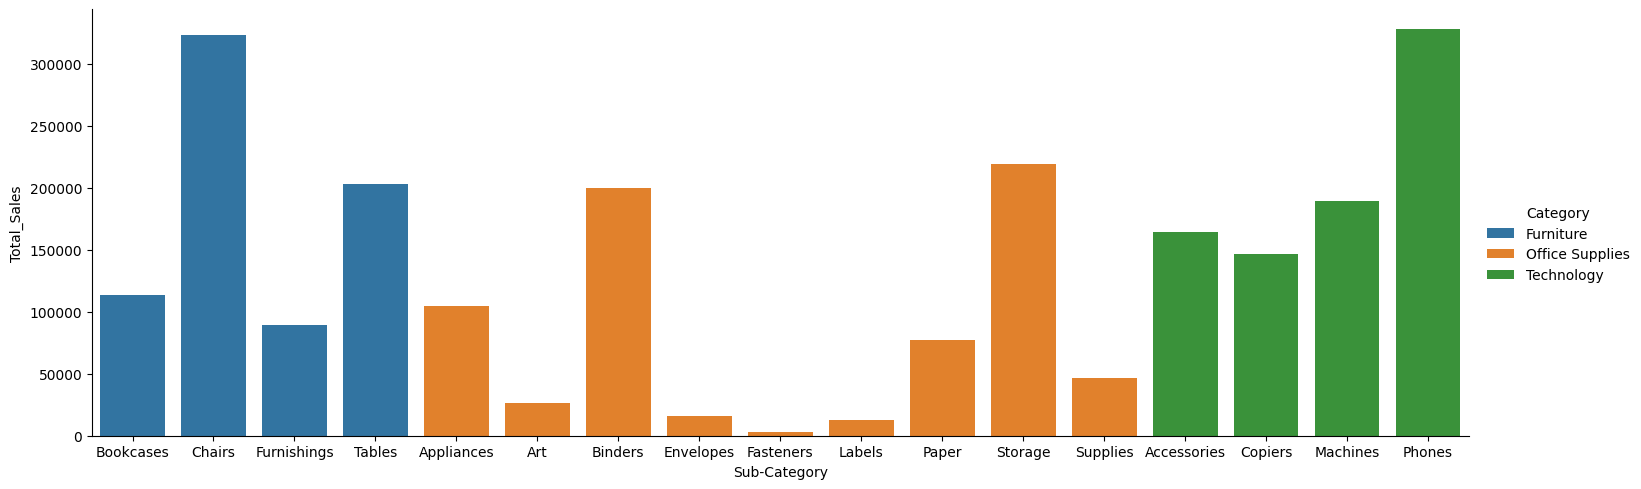

In [ ]:
sales_by_category = data.groupby(['Category', 'Sub-Category']).agg(Total_Sales = ('Sales', 'sum'), Average_Sales = ('Sales', 'mean'), Order_Numbers = ('Sales', 'count')).reset_index()
total_sales_by_category_bar = sns.catplot(data = sales_by_category, x = "Sub-Category", y = "Total_Sales", hue = "Category", kind = "bar", palette = sns.color_palette(), aspect = 3, dodge = False)
# average_sales_by_category_bar = sns.catplot(data = sales_by_category, x = "Sub-Category", y = "Average_Sales", hue = "Category", kind = "bar", palette = sns.color_palette(), aspect = 3, dodge = False)
# order_numbers_by_category_bar = sns.catplot(data = sales_by_category, x = "Sub-Category", y = "Order_Numbers", hue = "Category", kind = "bar", palette = sns.color_palette(), aspect = 3, dodge = False)

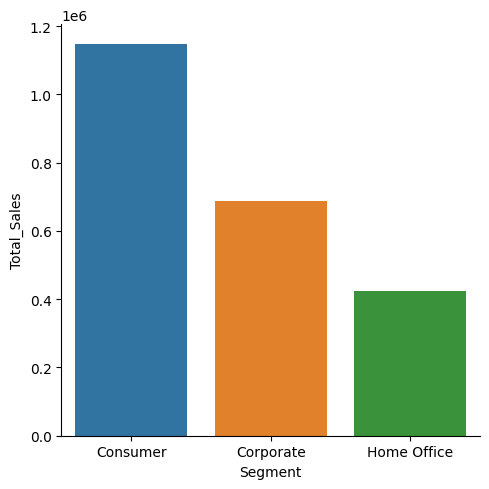

In [ ]:
sales_by_segment = data.groupby('Segment').agg(Total_Sales = ('Sales', 'sum'), Average_Sales = ('Sales', 'mean'), Order_Numbers = ('Sales', 'count')).reset_index()
total_sales_by_segment_bar = sns.catplot(data = sales_by_segment, x = "Segment", y = "Total_Sales", hue = "Segment", kind = "bar", palette = sns.color_palette(), dodge = False)
# average_sales_by_segment_bar = sns.catplot(data = sales_by_segment, x = "Segment", y = "Average_Sales", hue = "Segment", kind = "bar", palette = sns.color_palette(), dodge = False)
# order_numbers_by_segment_bar = sns.catplot(data = sales_by_segment, x = "Segment", y = "Order_Numbers", hue = "Segment", kind = "bar", palette = sns.color_palette(), dodge = False)

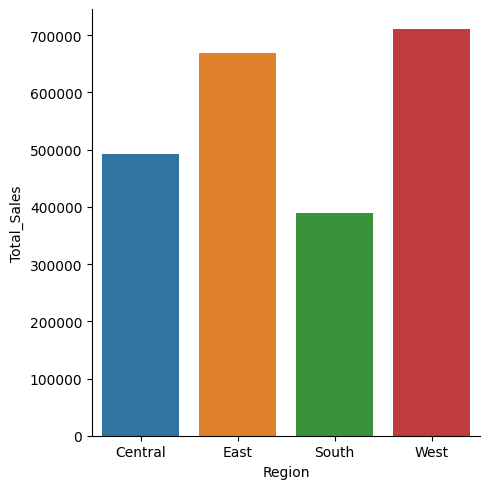

In [ ]:
sales_by_region = data.groupby('Region').agg(Total_Sales = ('Sales', 'sum'), Average_Sales = ('Sales', 'mean'), Order_Numbers = ('Sales', 'count')).reset_index()
total_sales_by_region_bar = sns.catplot(data = sales_by_region, x = "Region", y = "Total_Sales", hue = "Region", kind = "bar", palette = sns.color_palette(), dodge = False)
# average_sales_by_region_bar = sns.catplot(data = sales_by_region, x = "Region", y = "Average_Sales", hue = "Region", kind = "bar", palette = sns.color_palette(), dodge = False)
# order_numbers_by_segment_bar = sns.catplot(data = sales_by_region, x = "Region", y = "Order_Numbers", hue = "Region", kind = "bar", palette = sns.color_palette(), dodge = False)

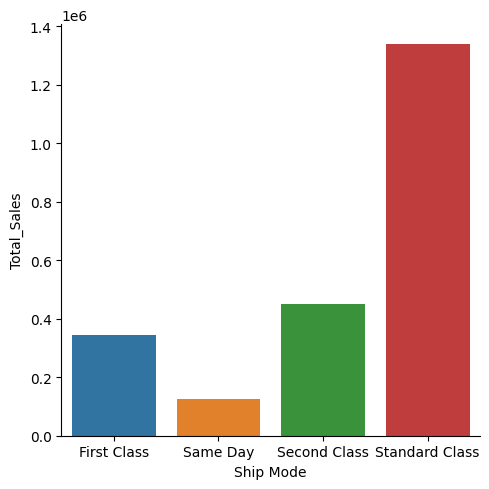

In [ ]:
sales_by_shipmode = data.groupby('Ship Mode').agg(Total_Sales = ('Sales', 'sum'), Average_Sales = ('Sales', 'mean'), Order_Numbers = ('Sales', 'count')).reset_index()
total_sales_by_shipmode_bar = sns.catplot(data = sales_by_shipmode, x = "Ship Mode", y = "Total_Sales", hue = "Ship Mode", kind = "bar", palette = sns.color_palette(), dodge = False)
# average_sales_by_shipmode_bar = sns.catplot(data = sales_by_shipmode, x = "Ship Mode", y = "Average_Sales", hue = "Ship Mode", kind = "bar", palette = sns.color_palette(), dodge = False)
# order_numbers_by_shipmode_bar = sns.catplot(data = sales_by_shipmode, x = "Ship Mode", y = "Order_Numbers", hue = "Ship Mode", kind = "bar", palette = sns.color_palette(), dodge = False)

In [ ]:
data['Year'] = data['Order Date'].dt.year
data['Month'] = data['Order Date'].dt.month
data['Week'] = data['Order Date'].dt.week
data['Date'] = pd.to_datetime(data['Year'].astype(str) + '-' + data['Month'].astype(str), format = '%Y-%m')
data['Weekly_Date'] = pd.to_datetime(data['Year'].astype(str) + '-' + data['Week'].astype(str)  + '1', format = '%Y-%W%w')
monthly_sales = data.groupby('Date').agg(Total_Sales = ('Sales', 'sum'), Average_Sales = ('Sales', 'mean'), Order_Numbers = ('Sales', 'count')).reset_index()
weekly_sales = data.groupby('Weekly_Date').agg(Total_Sales = ('Sales', 'sum'), Average_Sales = ('Sales', 'mean'), Order_Numbers = ('Sales', 'count')).reset_index()
daily_sales = data.groupby('Order Date').agg(Total_Sales = ('Sales', 'sum'), Average_Sales = ('Sales', 'mean'), Order_Numbers = ('Sales', 'count')).reset_index()

Text(0.5, 1.0, 'Monthly Total Sales')

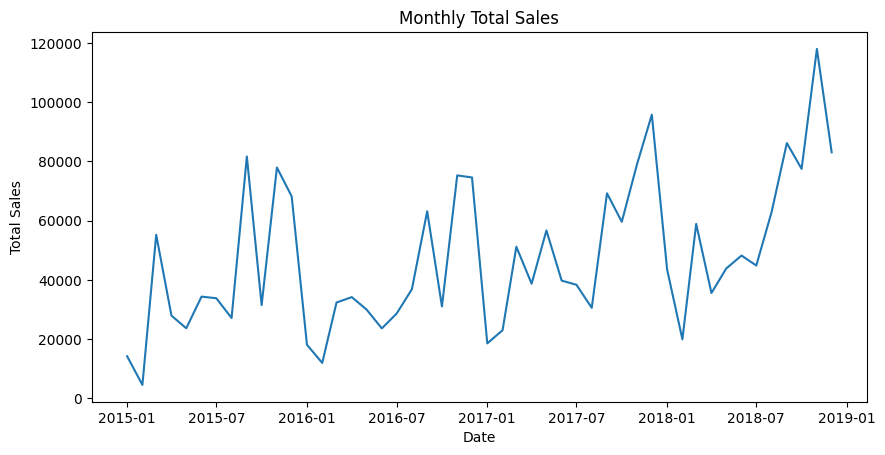

In [ ]:
plt.figure().set_figwidth(10)
plt.plot(monthly_sales['Date'], monthly_sales['Total_Sales'])
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.title('Monthly Total Sales')

Text(0.5, 1.0, 'Weekly Total Sales')

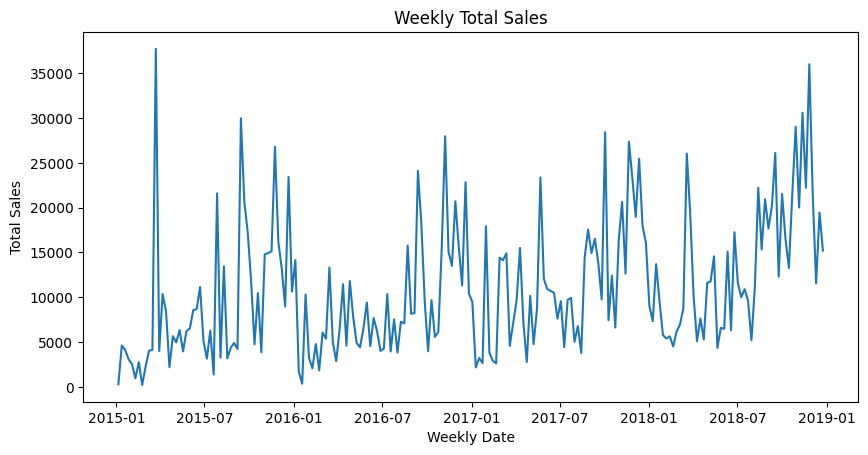

In [ ]:
plt.figure().set_figwidth(10)
plt.plot(weekly_sales['Weekly_Date'], weekly_sales['Total_Sales'])
plt.xlabel('Weekly Date')
plt.ylabel('Total Sales')
plt.title('Weekly Total Sales')

In [ ]:
# plt.figure().set_figwidth(10)
# plt.plot(monthly_sales['Date'], monthly_sales['Average_Sales'])
# plt.xlabel('Date')
# plt.ylabel('Average Sales')
# plt.title('Monthly Average Sales')

In [ ]:
# plt.figure().set_figwidth(10)
# plt.plot(monthly_sales['Date'], monthly_sales['Order_Numbers'])
# plt.xlabel('Date')
# plt.ylabel('Order Numbers')
# plt.title('Monthly Order Numbers')

Text(0.5, 1.0, 'Daily Total Sales')

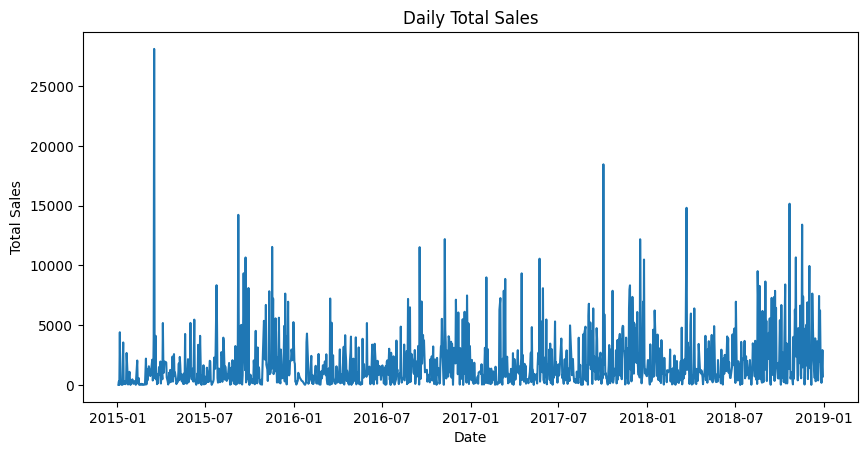

In [ ]:
plt.figure().set_figwidth(10)
plt.plot(daily_sales['Order Date'], daily_sales['Total_Sales'])
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.title('Daily Total Sales')

# Decomposition of Sales into Trend, Seasonal, and Residual

In [ ]:
monthly_sales_idx = monthly_sales.set_index('Date')
daily_sales_idx = daily_sales.set_index('Order Date')
daily_sales_idx.index.names = ['Date']

In [ ]:
weekly_sales_idx = weekly_sales.set_index('Weekly_Date')
weekly_sales_idx.index.names = ['Date']

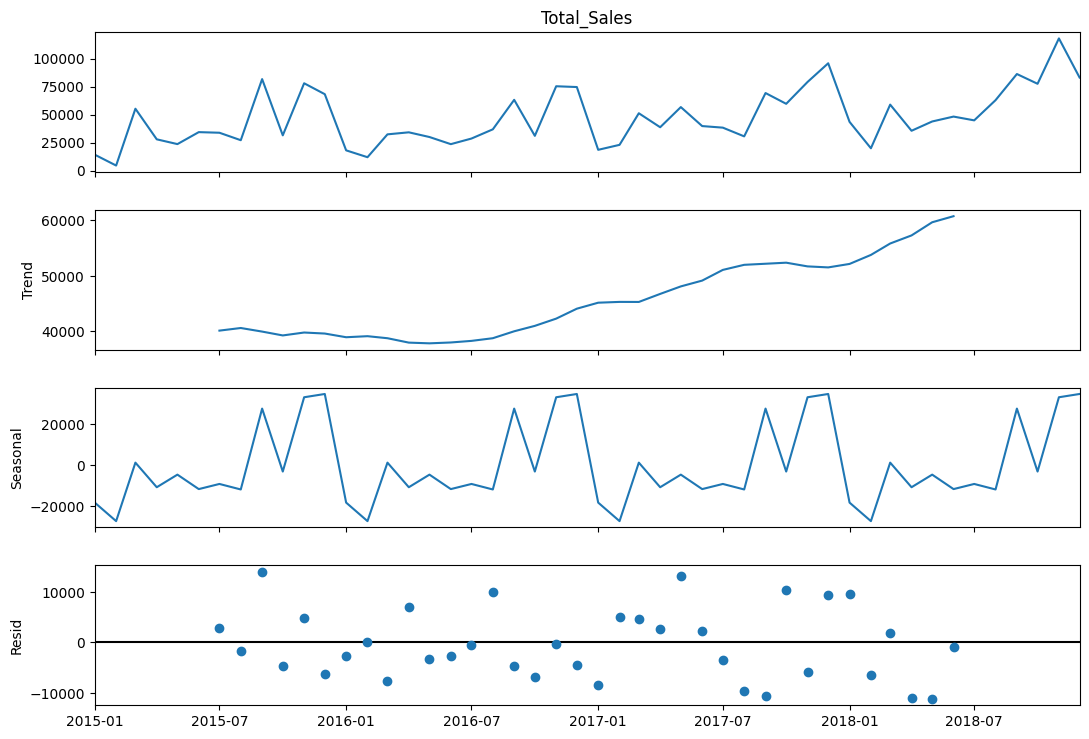

In [ ]:
monthly_total_sales_decomp = seasonal_decompose(monthly_sales_idx['Total_Sales'], model = 'additive')
monthly_total_sales_decomp_plots = monthly_total_sales_decomp.plot()
monthly_total_sales_decomp_plots.set_size_inches((12, 8))
plt.show()

In [ ]:
# monthly_average_sales_decomp = seasonal_decompose(monthly_sales_idx['Average_Sales'], model = 'additive')
# monthly_average_sales_decomp_plots = monthly_average_sales_decomp.plot()
# monthly_average_sales_decomp_plots.set_size_inches((12, 8))
# plt.show()

In [ ]:
# monthly_order_numbers_decomp = seasonal_decompose(monthly_sales_idx['Order_Numbers'], model = 'additive')
# monthly_order_numbers_decomp_plots = monthly_order_numbers_decomp.plot()
# monthly_order_numbers_decomp_plots.set_size_inches((12, 8))
# plt.show()

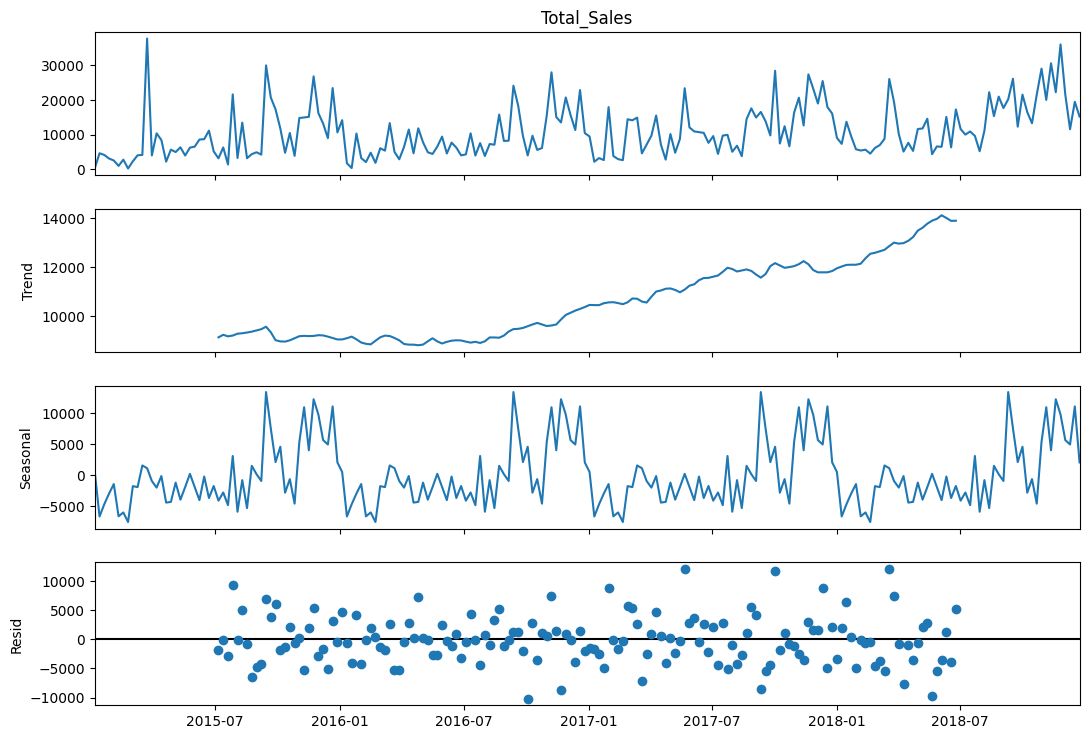

In [ ]:
weekly_total_sales_decomp = seasonal_decompose(weekly_sales_idx['Total_Sales'], model = 'additive', period = 52)
weekly_total_sales_decomp_plots = weekly_total_sales_decomp.plot()
weekly_total_sales_decomp_plots.set_size_inches((12, 8))
plt.show()

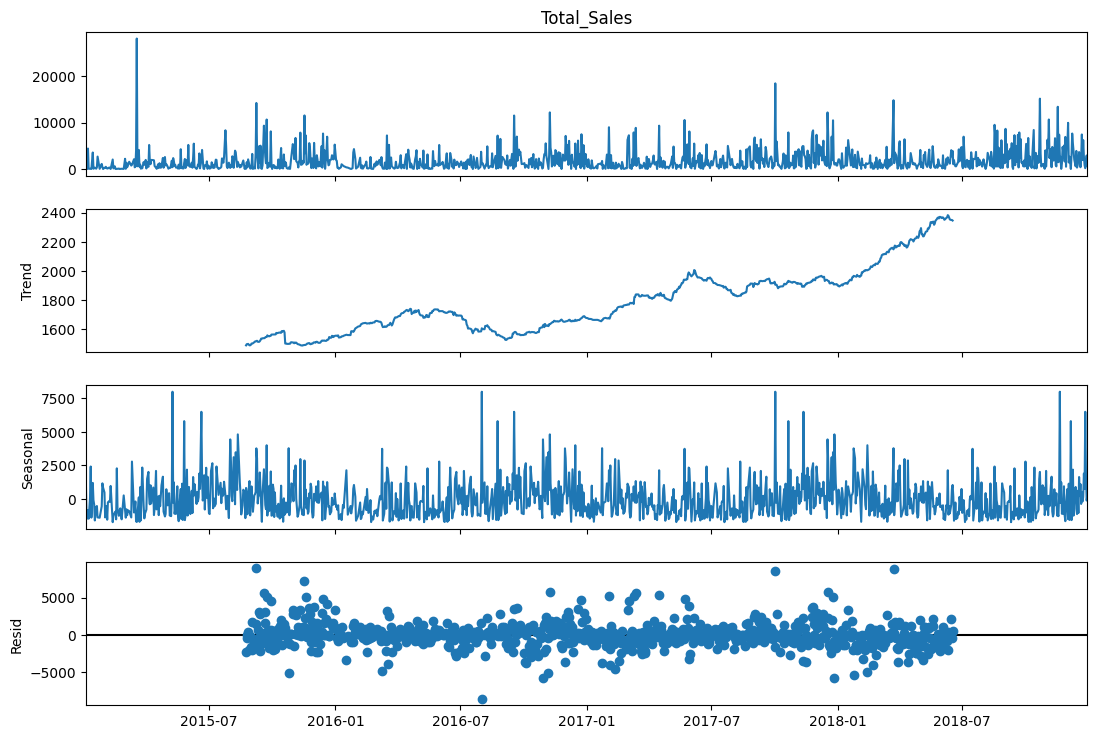

In [ ]:
daily_total_sales_decomp = seasonal_decompose(daily_sales_idx['Total_Sales'], model = 'additive', period = 365)
daily_total_sales_decomp_plots = daily_total_sales_decomp.plot()
daily_total_sales_decomp_plots.set_size_inches((12, 8))
plt.show()

In [ ]:
# daily_average_sales_decomp = seasonal_decompose(daily_sales_idx['Average_Sales'], model = 'additive', period = 365)
# daily_average_sales_decomp_plots = daily_average_sales_decomp.plot()
# daily_average_sales_decomp_plots.set_size_inches((12, 8))
# plt.show()

In [ ]:
# daily_order_numbers_decomp = seasonal_decompose(daily_sales_idx['Order_Numbers'], model = 'additive', period = 365)
# daily_order_numbers_decomp_plots = daily_order_numbers_decomp.plot()
# daily_order_numbers_decomp_plots.set_size_inches((12, 8))
# plt.show()

# Moving Average (MA)

In [ ]:
def plot_moving_average(series, window, plot_intervals=False, scale=1.96):

    rolling_mean = series.rolling(window=window).mean()

    plt.figure(figsize=(17,8))
    plt.title('Moving average\n window size = {}'.format(window))
    plt.plot(rolling_mean, 'g', label='Rolling mean trend')

    #Plot confidence intervals for smoothed values
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bound = rolling_mean - (mae + scale * deviation)
        upper_bound = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bound, 'r--', label='Upper bound / Lower bound')
        plt.plot(lower_bound, 'r--')

    plt.plot(series[window:], label='Actual values')
    plt.legend(loc='best')
    plt.grid(True)


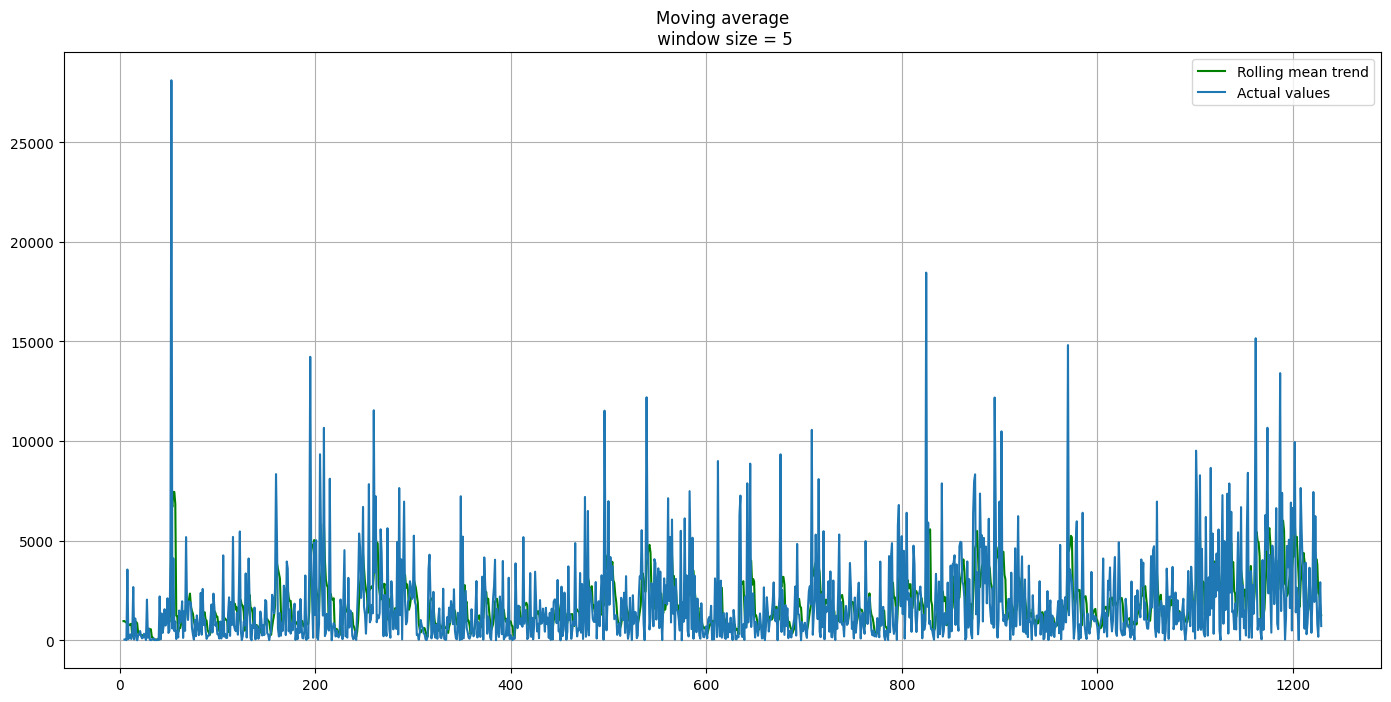

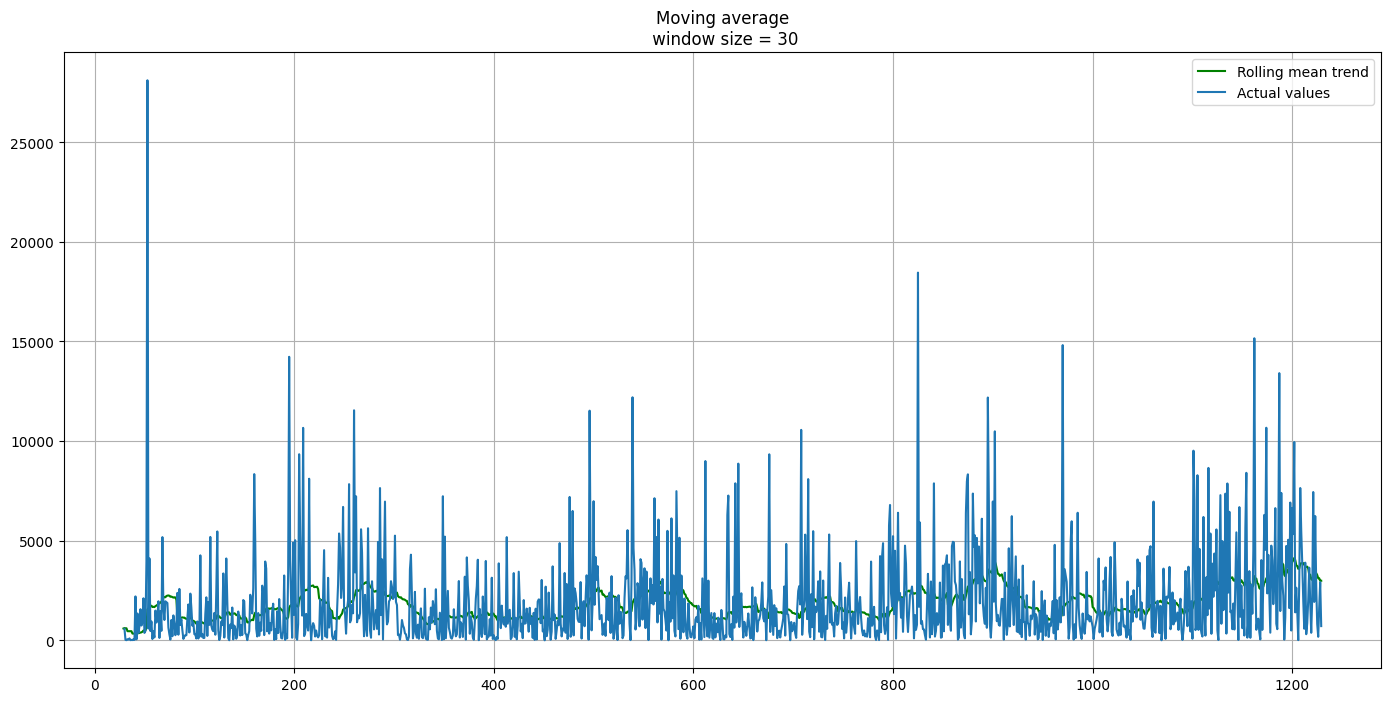

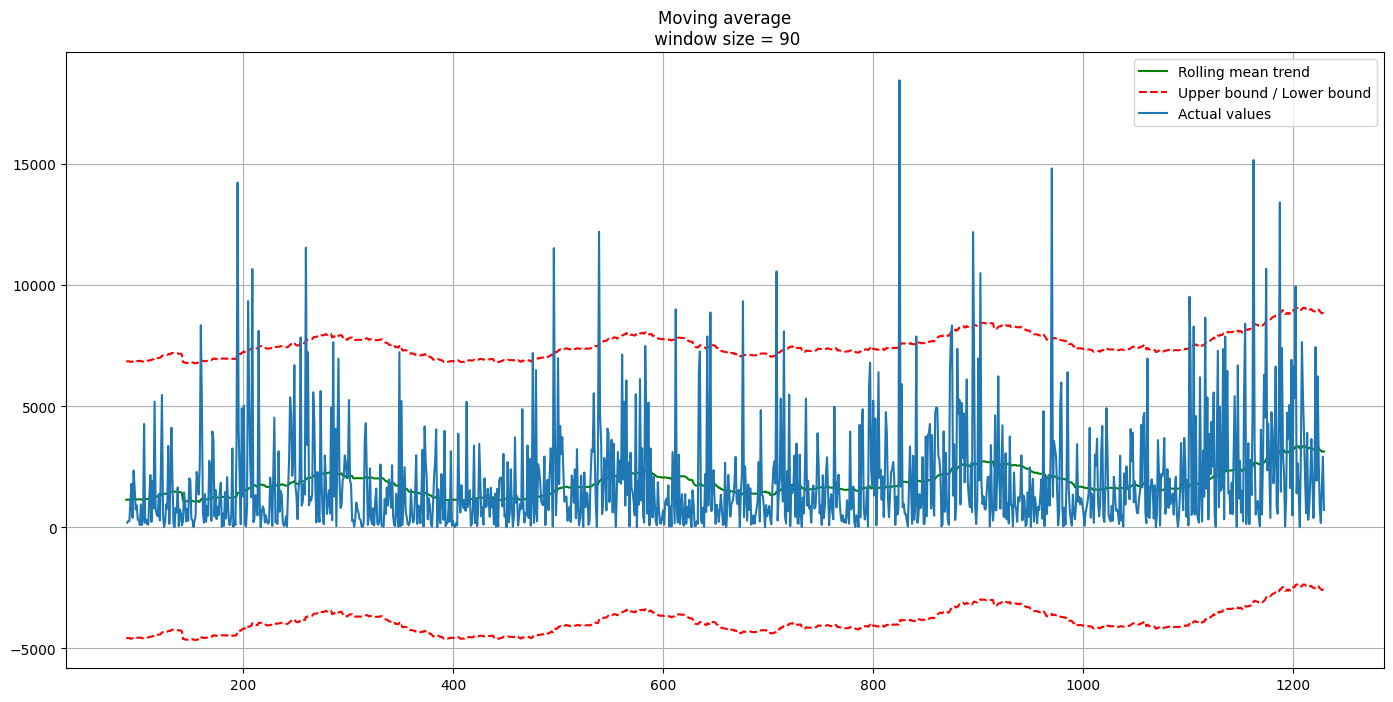

In [ ]:
#Smooth by the previous 5 days (by week)
plot_moving_average(daily_sales.Total_Sales, 5)

#Smooth by the previous month (30 days)
plot_moving_average(daily_sales.Total_Sales, 30)

#Smooth by previous quarter (90 days)
plot_moving_average(daily_sales.Total_Sales, 90, plot_intervals=True)

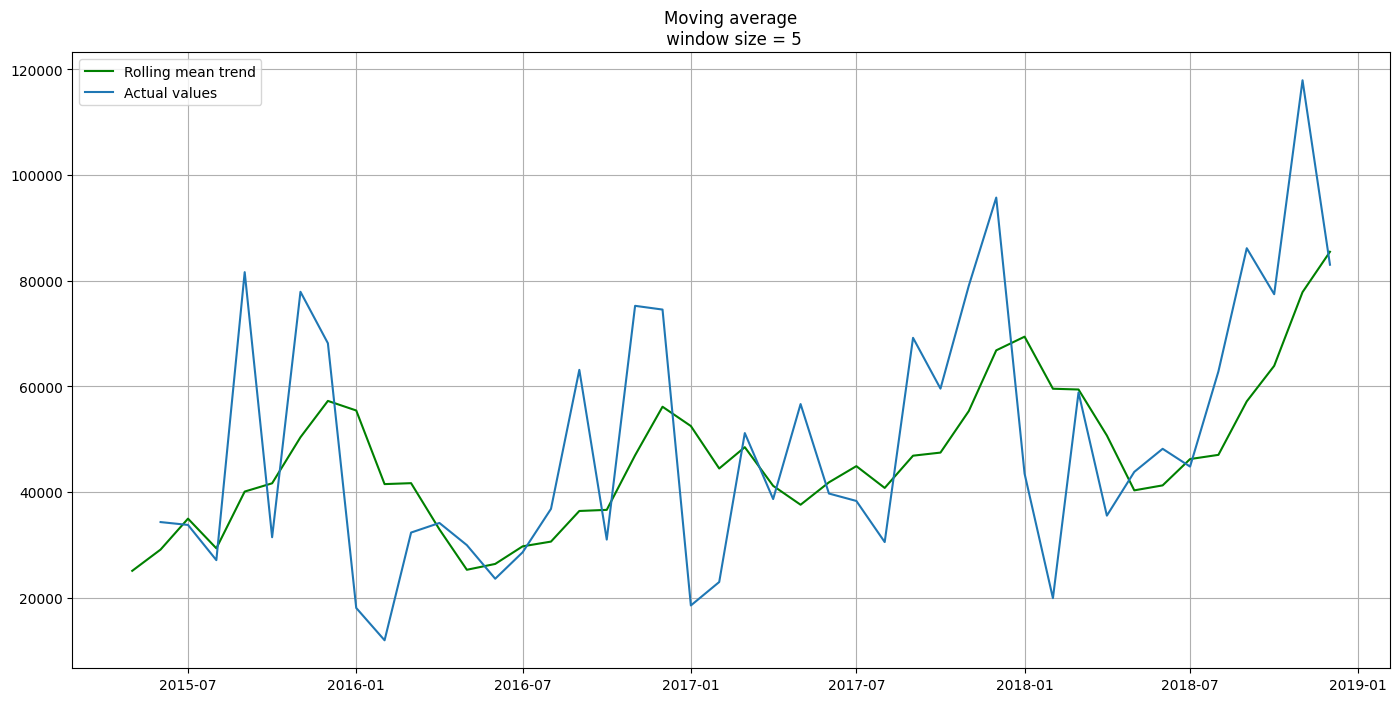

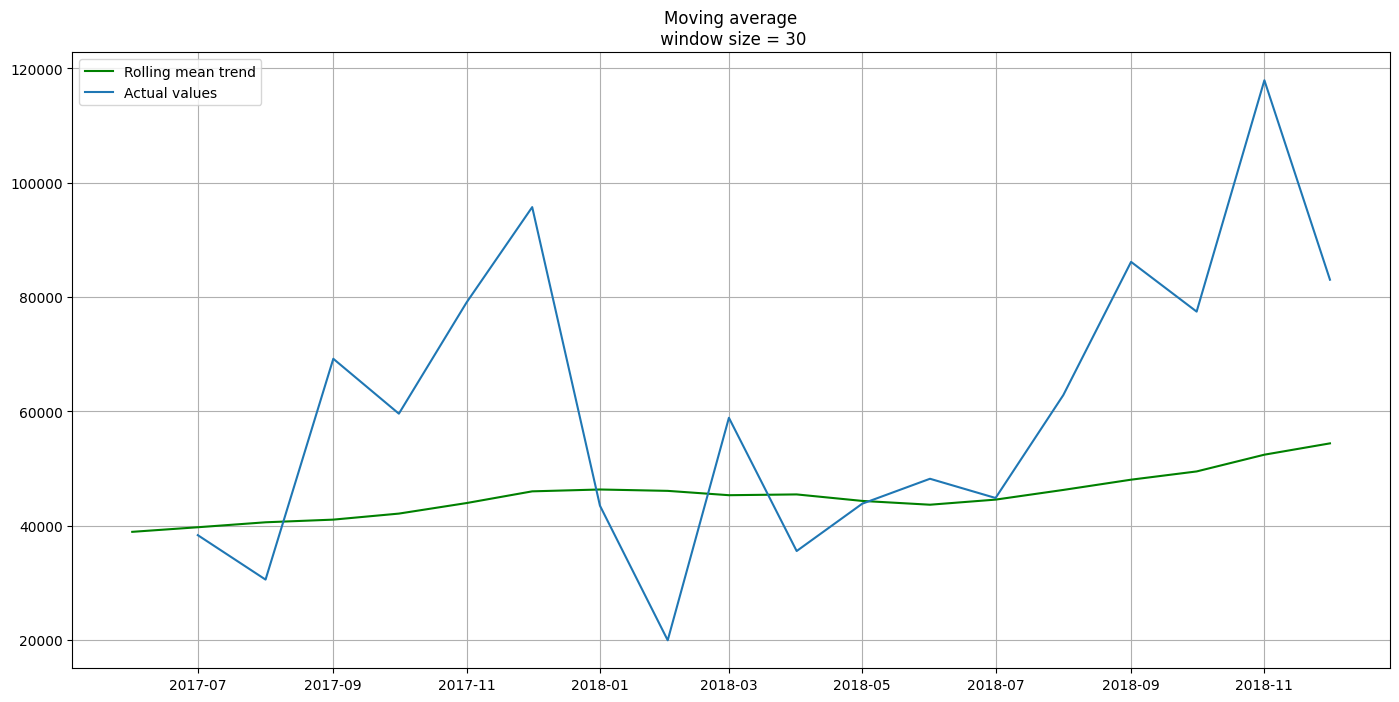

In [ ]:
#Smooth by the previous 5 days (by week)
plot_moving_average(monthly_sales_idx.Total_Sales, 5)

#Smooth by the previous month (30 days)
plot_moving_average(monthly_sales_idx.Total_Sales, 30)

# Exponential Smoothing

In [ ]:
def exponential_smoothing(series, alpha):

    result = [series[0]] # first value is same as series
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result

def plot_exponential_smoothing(series, alphas):

    plt.figure(figsize=(17, 8))
    for alpha in alphas:
        plt.plot(exponential_smoothing(series, alpha), label="Alpha {}".format(alpha))
    plt.plot(series.values, "c", label = "Actual")
    plt.legend(loc="best")
    plt.axis('tight')
    plt.title("Exponential Smoothing")
    plt.grid(True);

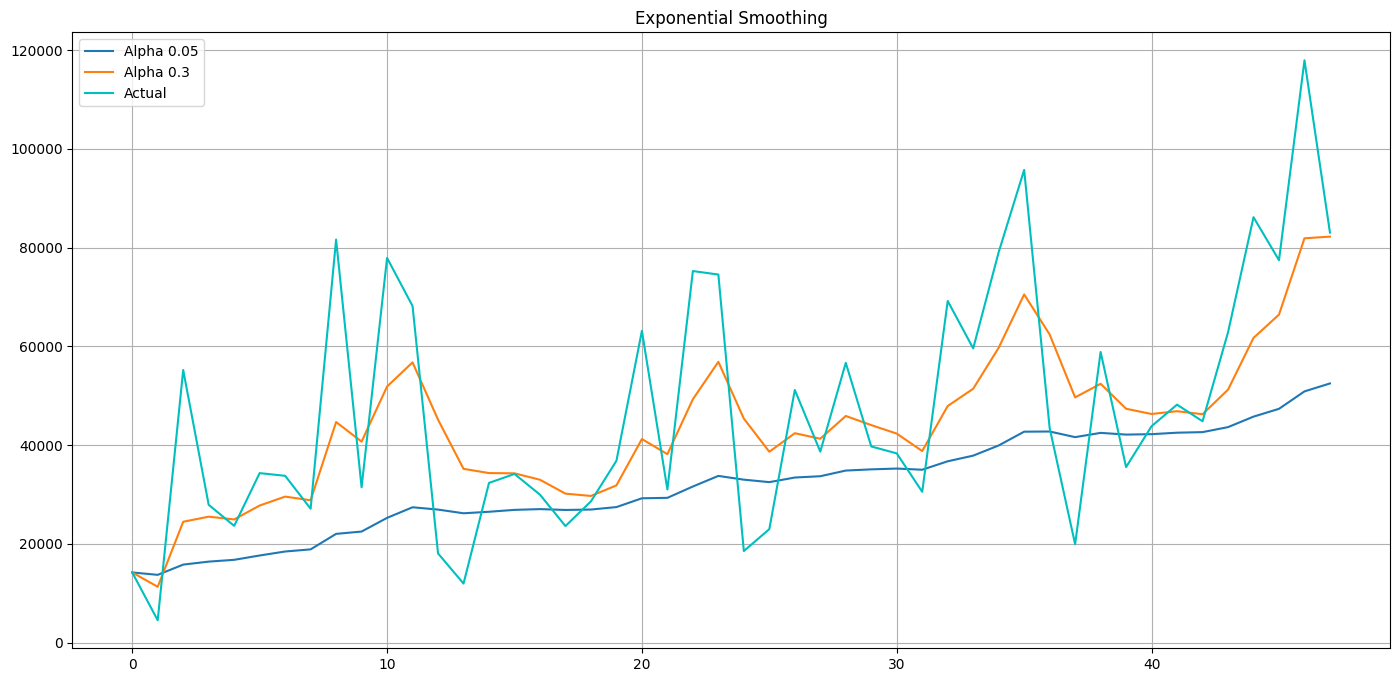

In [ ]:
# plot_exponential_smoothing(daily_sales.Total_Sales, [0.05, 0.3])
plot_exponential_smoothing(monthly_sales_idx.Total_Sales, [0.05, 0.3])

# Double Exponential Smoothing

In [ ]:
def double_exponential_smoothing(series, alpha, beta):

    result = [series[0]]
    for n in range(1, len(series)+1):
        if n == 1:
            level, trend = series[0], series[1] - series[0]
        if n >= len(series): # forecasting
            value = result[-1]
        else:
            value = series[n]
        last_level, level = level, alpha * value + (1 - alpha) * (level + trend)
        trend = beta * (level - last_level) + (1 - beta) * trend
        result.append(level + trend)
    return result

def plot_double_exponential_smoothing(series, alphas, betas):

    plt.figure(figsize=(17, 8))
    for alpha in alphas:
        for beta in betas:
            plt.plot(double_exponential_smoothing(series, alpha, beta), label="Alpha {}, beta {}".format(alpha, beta))
    plt.plot(series.values, label = "Actual")
    plt.legend(loc="best")
    plt.axis('tight')
    plt.title("Double Exponential Smoothing")
    plt.grid(True)

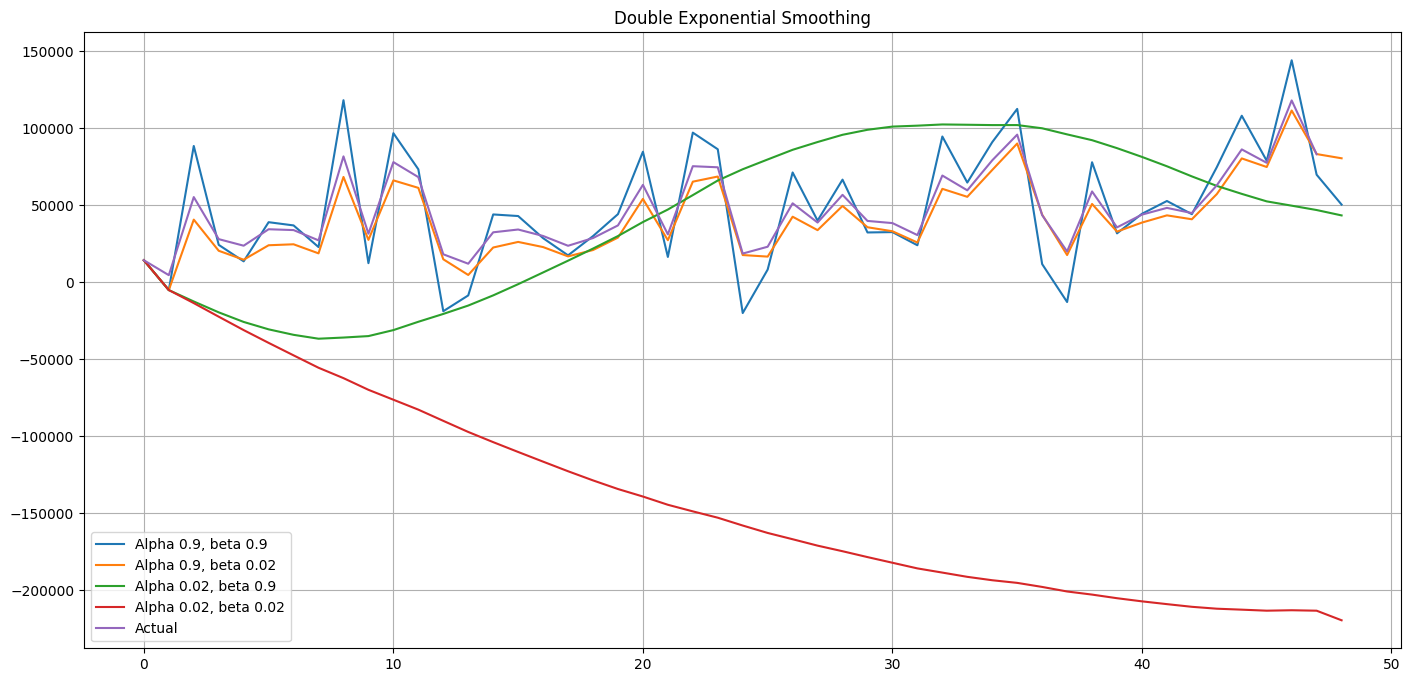

In [ ]:
# plot_double_exponential_smoothing(daily_sales.Total_Sales, alphas=[0.9, 0.02], betas=[0.9, 0.02])
plot_double_exponential_smoothing(monthly_sales_idx.Total_Sales, alphas=[0.9, 0.02], betas=[0.9, 0.02])

# Dickey-Fuller Test for Stationary Check

In [ ]:
def tsplot(y, lags=None, figsize=(12, 7), syle='bmh'):

    if not isinstance(y, pd.Series):
        y = pd.Series(y)

    with plt.style.context(style='bmh'):
        fig = plt.figure(figsize=figsize)
        layout = (2,2)
        ts_ax = plt.subplot2grid(layout, (0,0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1,0))
        pacf_ax = plt.subplot2grid(layout, (1,1))

        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()

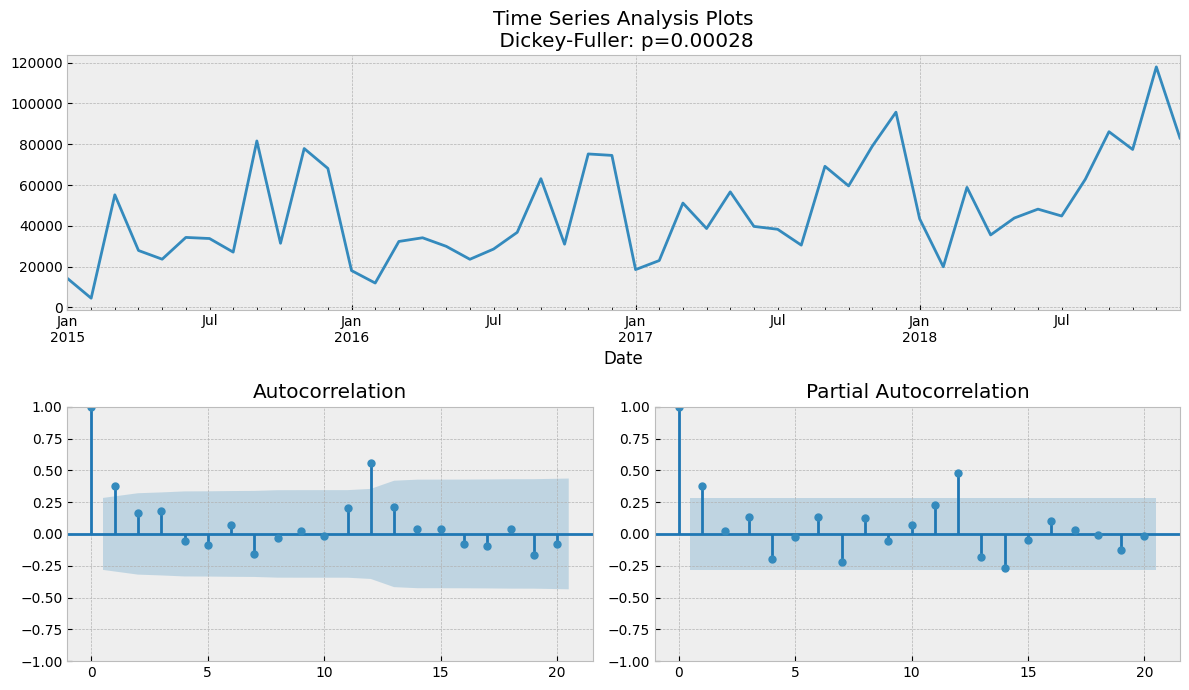

In [ ]:
# tsplot(daily_sales.Total_Sales, lags=30)
tsplot(monthly_sales_idx.Total_Sales, lags=20)

# tsplot(daily_sales.Average_Sales, lags=30)
# tsplot(daily_sales.Order_Numbers, lags=30)


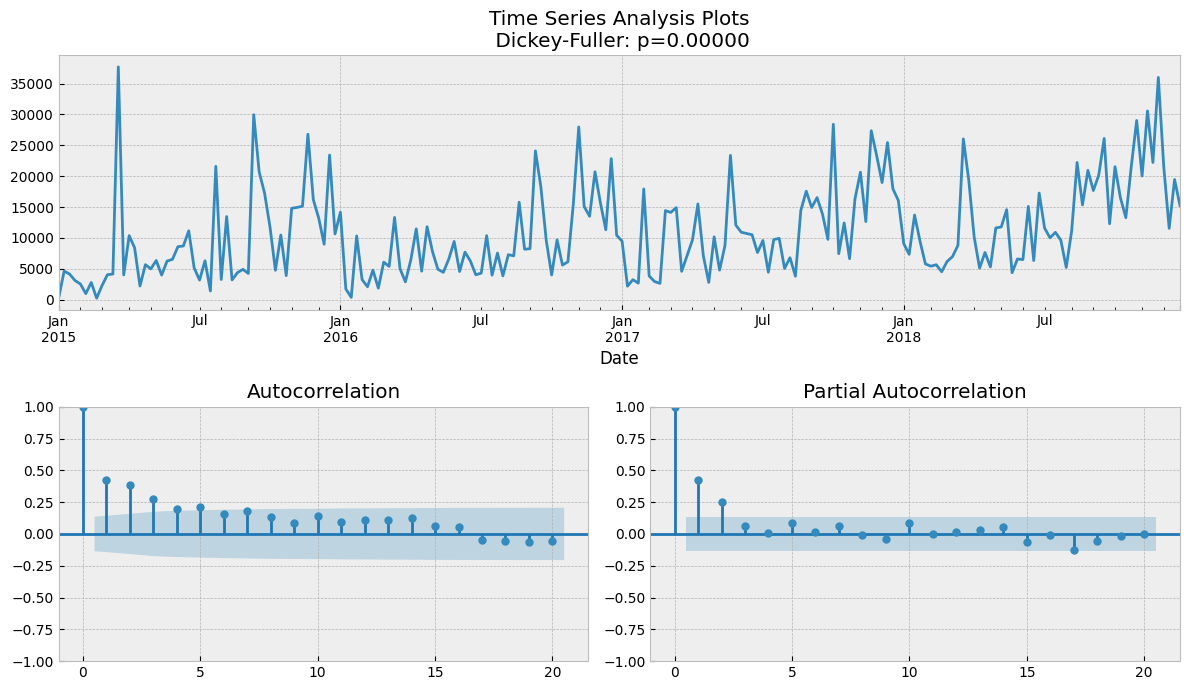

In [ ]:
tsplot(weekly_sales_idx.Total_Sales, lags=20)

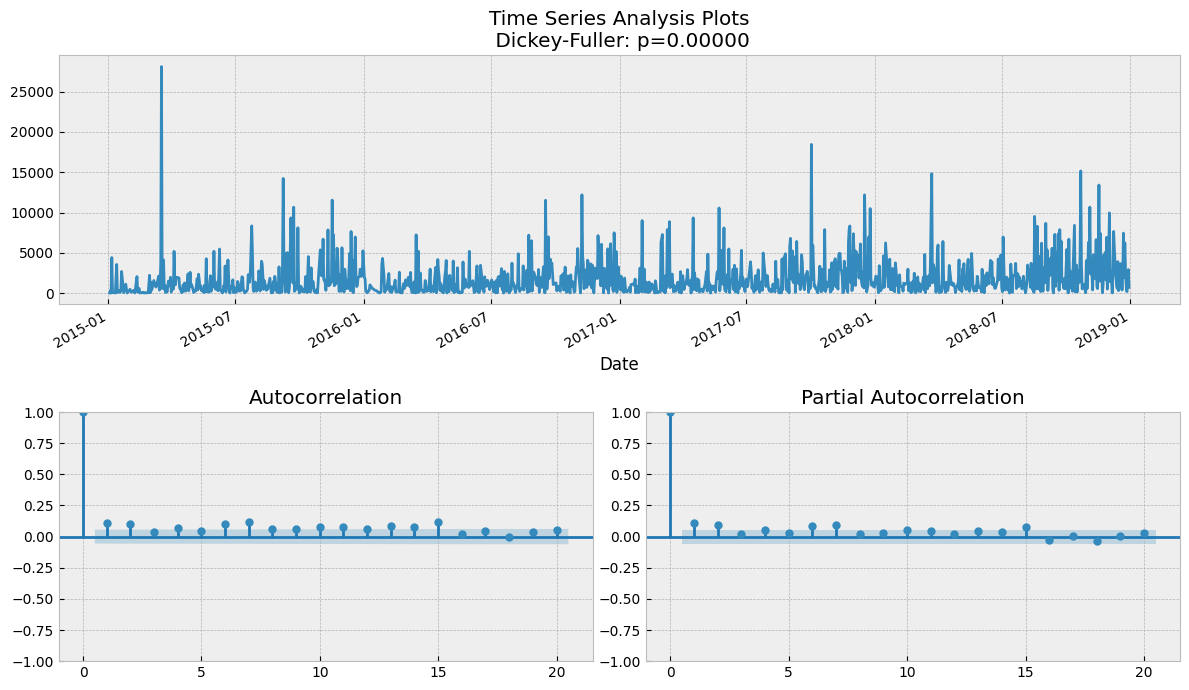

In [ ]:
tsplot(daily_sales_idx.Total_Sales, lags=20)

# SARIMA Model
**Non-seasonal Parameters**
* p: Autoregressive order (the number of lagged values or autoregressive terms)
* q: Differencing order (degree of differencing or integration)
* r: Moving average order (the number of moving average terms or error terms)

**Seasonal Parameters**
* P: Seasonal autoregressive order
* D: Seasonal differencing order
* Q: Seasonal moving average order
* S: Seasonal period



In [ ]:
sarima_monthly_df = monthly_sales_idx[['Total_Sales']]
sarima_monthly_df.index = pd.DatetimeIndex(sarima_monthly_df.index.values, freq=sarima_monthly_df.index.inferred_freq)
warnings.simplefilter("ignore", Warning)
sarima_monthly_df_train = sarima_monthly_df.loc[:'2017']
sarima_monthly_df_test = sarima_monthly_df.loc['2018':]

In [ ]:
sarima_weekly_df = weekly_sales_idx[['Total_Sales']]
sarima_weekly_df.index = pd.DatetimeIndex(sarima_weekly_df.index.values, freq=sarima_weekly_df.index.inferred_freq)
warnings.simplefilter("ignore", Warning)
sarima_weekly_df_train = sarima_weekly_df.loc[:'2017']
sarima_weekly_df_test = sarima_weekly_df.loc['2018':]

In [ ]:
# Initialize params
p_vals = range(0, 3)
d_vals = [0]
q_vals = range(0, 3)
P_vals = range(0, 3)
D_vals = [0]
Q_vals = range(0, 3)
m_vals_monthly = [12]
m_vals_weekly = [52]

# Create all possible combinations of SARIMA parameters
monthly_param_combinations = list(itertools.product(p_vals, d_vals, q_vals, P_vals, D_vals, Q_vals, m_vals_monthly))
weekly_param_combinations = list(itertools.product(p_vals, d_vals, q_vals, P_vals, D_vals, Q_vals, m_vals_weekly))

In [ ]:
# Initialize AIC with a large value
monthly_best_aic = float("inf")
monthly_best_params = None

# Perform grid search
for params in monthly_param_combinations:
    order = params[:3]
    seasonal_order = params[3:]

    try:
        model = SARIMAX(sarima_monthly_df_train,
                        order=order,
                        seasonal_order=seasonal_order)
        result = model.fit(disp=False)
        aic = result.aic

        # Ensure the convergence of the model
        if not math.isinf(result.zvalues.mean()):
            print(order, seasonal_order, aic)

            if aic < monthly_best_aic:
                monthly_best_aic = aic
                monthly_best_params = params

        else:
            print(order, seasonal_order, 'not converged')
    except:
        continue

(0, 0, 0) (0, 0, 0, 12) 880.891059558751
(0, 0, 0) (0, 0, 1, 12) 865.9208970006002
(0, 0, 0) (0, 0, 2, 12) 852.5237139671627
(0, 0, 0) (1, 0, 0, 12) 821.390359959272
(0, 0, 0) (1, 0, 1, 12) 833.2886616470818
(0, 0, 0) (1, 0, 2, 12) 834.8313905312145
(0, 0, 0) (2, 0, 0, 12) 822.6497144140078
(0, 0, 0) (2, 0, 1, 12) 835.2763876421458
(0, 0, 0) (2, 0, 2, 12) 836.8347606960928
(0, 0, 1) (0, 0, 0, 12) 868.1565722552019
(0, 0, 1) (0, 0, 1, 12) 865.9456431561441
(0, 0, 1) (0, 0, 2, 12) 866.3778138173312
(0, 0, 1) (1, 0, 0, 12) 863.7923910469418
(0, 0, 1) (1, 0, 1, 12) 865.6058364790214
(0, 0, 1) (1, 0, 2, 12) 867.6011828574283
(0, 0, 1) (2, 0, 0, 12) 865.6019737241888
(0, 0, 1) (2, 0, 1, 12) 867.6011395472216
(0, 0, 1) (2, 0, 2, 12) 869.6015957004524
(0, 0, 2) (0, 0, 0, 12) 868.6877989432194
(0, 0, 2) (0, 0, 1, 12) 867.9648317152887
(0, 0, 2) (0, 0, 2, 12) 868.9938460514288
(0, 0, 2) (1, 0, 0, 12) 866.7587887718473
(0, 0, 2) (1, 0, 1, 12) 868.6254112559358
(0, 0, 2) (1, 0, 2, 12) 870.61894125

In [ ]:
# Initialize AIC with a large value
weekly_best_aic = float("inf")
weekly_best_params = None

# Perform grid search
for params in weekly_param_combinations:
    order = params[:3]
    seasonal_order = params[3:]

    try:
        model = SARIMAX(sarima_weekly_df_train,
                        order=order,
                        seasonal_order=seasonal_order)
        result = model.fit(disp=False)
        aic = result.aic

        # Ensure the convergence of the model
        if not math.isinf(result.zvalues.mean()):
            print(order, seasonal_order, aic)

            if aic < weekly_best_aic:
                weekly_best_aic = aic
                weekly_best_params = params

        else:
            print(order, seasonal_order, 'not converged')
    except:
        continue

(0, 0, 0) (0, 0, 0, 52) 3378.1577719202196
(0, 0, 0) (0, 0, 1, 52) 3322.5686042605116
(0, 0, 0) (0, 0, 2, 52) 3286.0878856783484
(0, 0, 0) (1, 0, 0, 52) 3261.603063589467
(0, 0, 0) (1, 0, 1, 52) 3260.9286541514125
(0, 0, 0) (1, 0, 2, 52) 3262.809945951414
(0, 0, 0) (2, 0, 0, 52) 3260.1707138263628
(0, 0, 0) (2, 0, 1, 52) 3262.886404125693
(0, 0, 0) (2, 0, 2, 52) 3264.8071296550715
(0, 0, 1) (0, 0, 0, 52) 3323.756610115601
(0, 0, 1) (0, 0, 1, 52) 3311.866427246524
(0, 0, 1) (0, 0, 2, 52) 3308.654004936743
(0, 0, 1) (1, 0, 0, 52) 3305.5595111200755
(0, 0, 1) (1, 0, 1, 52) 3306.8210368834643
(0, 0, 1) (1, 0, 2, 52) 3308.781179810143
(0, 0, 1) (2, 0, 0, 52) 3306.7804672929324
(0, 0, 1) (2, 0, 1, 52) 3308.7795928658343
(0, 0, 1) (2, 0, 2, 52) 3310.781356302804
(0, 0, 2) (0, 0, 0, 52) 3301.8931886039313
(0, 0, 2) (0, 0, 1, 52) 3296.2550443442997
(0, 0, 2) (0, 0, 2, 52) 3295.5231236348063
(0, 0, 2) (1, 0, 0, 52) 3293.5246933000876
(0, 0, 2) (1, 0, 1, 52) 3294.8785037763887
(0, 0, 2) (1, 0, 2,

In [ ]:
# Print the best parameters and AIC
print("Monthly Best Parameters:", monthly_best_params)
print("Monthly Best AIC:", monthly_best_aic)

print("Weekly Best Parameters:", weekly_best_params)
print("Weekly Best AIC:", weekly_best_aic)

Monthly Best Parameters: (1, 0, 1, 1, 0, 0, 12)
Monthly Best AIC: 821.1231205482811
Weekly Best Parameters: (2, 0, 1, 1, 0, 0, 52)
Weekly Best AIC: 3184.751331884212


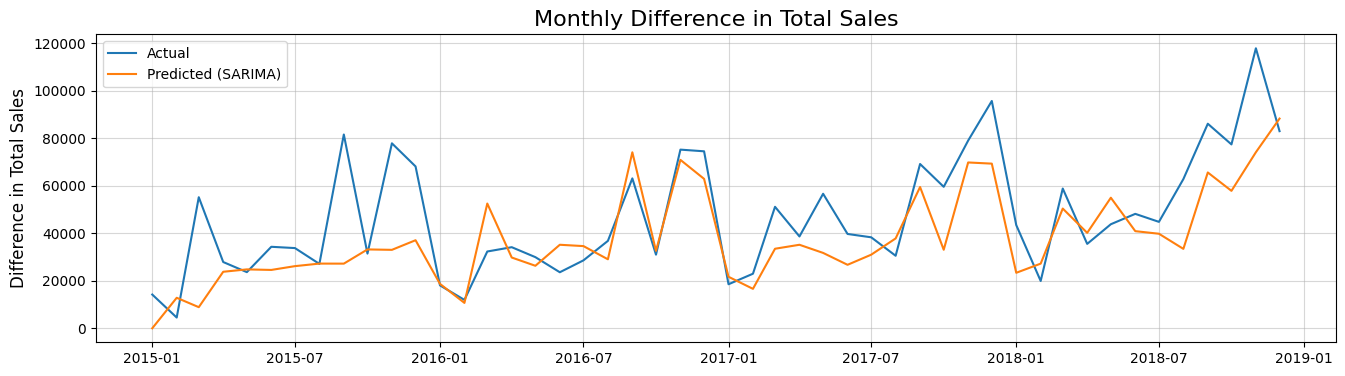

In [ ]:
sarima_monthly_best_params = SARIMAX(sarima_monthly_df['Total_Sales'], order=monthly_best_params[:3], seasonal_order=monthly_best_params[3:])
sarima_monthly_predictions = sarima_monthly_best_params.fit().predict()
plt.figure(figsize=(16,4))
plt.plot(sarima_monthly_df['Total_Sales'], label="Actual")
plt.plot(sarima_monthly_predictions, label="Predicted (SARIMA)")
plt.title('Monthly Total Sales', fontsize=16)
plt.ylabel('Total Sales', fontsize=12)
plt.grid(alpha=0.5)
plt.legend()

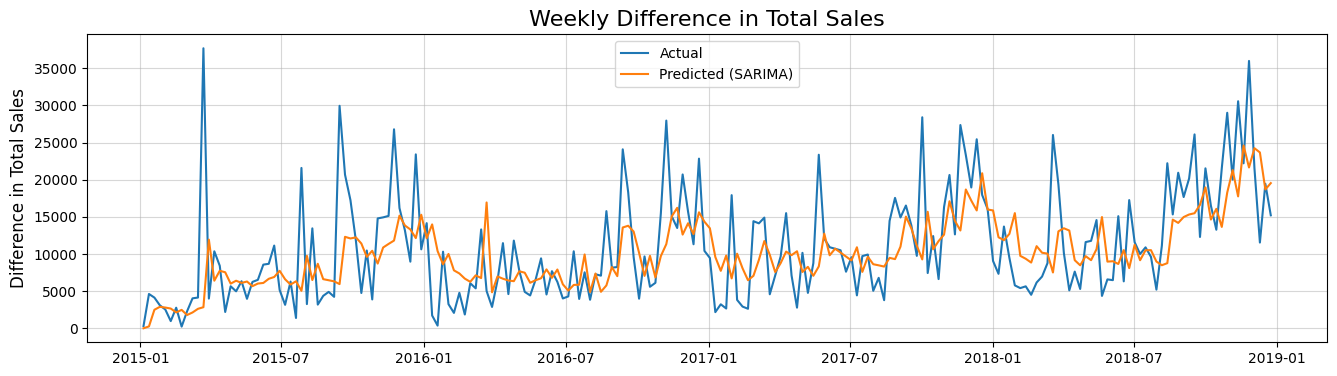

In [ ]:
sarima_weekly_best_params = SARIMAX(sarima_weekly_df['Total_Sales'], order=weekly_best_params[:3], seasonal_order=weekly_best_params[3:])
sarima_weekly_predictions = sarima_weekly_best_params.fit().predict()
plt.figure(figsize=(16,4))
plt.plot(sarima_weekly_df['Total_Sales'], label="Actual")
plt.plot(sarima_weekly_predictions, label="Predicted (SARIMA)")
plt.title('Weekly Total Sales', fontsize=16)
plt.ylabel('Total Sales', fontsize=12)
plt.grid(alpha=0.5)
plt.legend()

In [ ]:
sarima_monthly_model = SARIMAX(sarima_monthly_df_train, order=monthly_best_params[:3], seasonal_order=monthly_best_params[3:])
sarima_monthly_results = sarima_monthly_model.fit(disp=False)

# Show the summary
sarima_monthly_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                         Total_Sales   No. Observations:                   36
Model:             SARIMAX(1, 0, 1)x(1, 0, [], 12)   Log Likelihood                -406.562
Date:                             Wed, 03 Jan 2024   AIC                            821.123
Time:                                     20:21:38   BIC                            827.457
Sample:                                 01-01-2015   HQIC                           823.334
                                      - 12-01-2017                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9585      0.157      6.114      0.000       0.651       1.266
ma.L1         -0.6832      0.613     -1.115      0.265      -1.884       0.518
ar.S.L12       0.6588      0.243      2.713      0.007       0.183       1.135
sigma2      5.173e+08   2.42e-10   2.14e+18      0.000    5.17e+08    5.17e+08
===================================================================================
Ljung-Box (L1) (Q):                   0.24   Jarque-Bera (JB):                 1.27
Prob(Q):                              0.63   Prob(JB):                         0.53
Heteroskedasticity (H):               0.50   Skew:                             0.46
Prob(H) (two-sided):                  0.25   Kurtosis:                         3.01
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.63e+35. Standard errors may be unstable.
"""

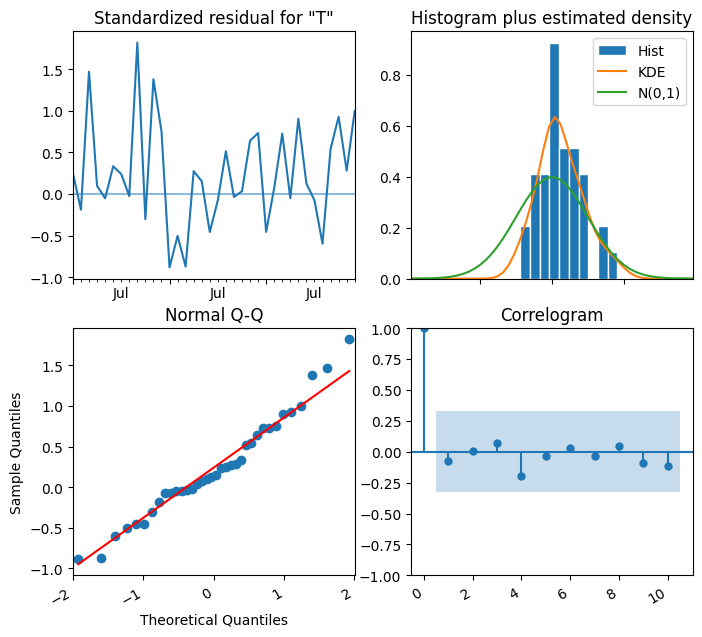

In [ ]:
# Display the model diagnostics
sarima_monthly_fig = sarima_monthly_results.plot_diagnostics(figsize=(8, 8))
sarima_monthly_fig.autofmt_xdate()
plt.show()

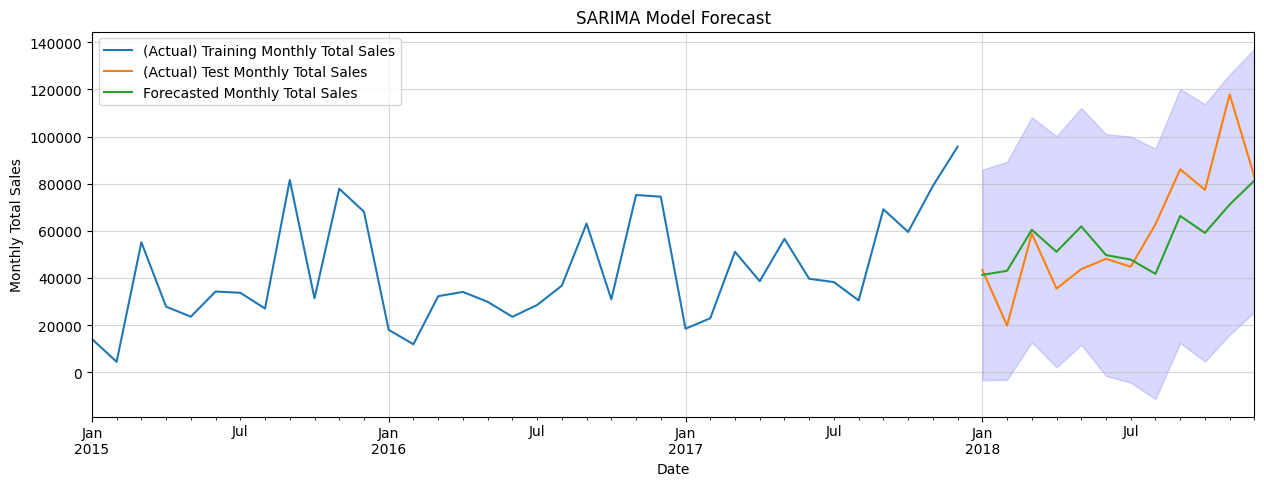

In [ ]:
# Get forecast and confidence intervals for two years
sarima_monthly_forecast = sarima_monthly_results.get_forecast(steps=12)
sarima_monthly_forecast_values = sarima_monthly_forecast.predicted_mean
monthly_confidence_intervals = sarima_monthly_forecast.conf_int()

# Plot forecast with training data
ax = sarima_monthly_df_train[-12*4:].plot(figsize=(15,5))
sarima_monthly_df_test.plot(ax=ax)
sarima_monthly_forecast_values.plot()
plt.fill_between(sarima_monthly_forecast_values.index,
                 monthly_confidence_intervals['lower Total_Sales'],
                 monthly_confidence_intervals['upper Total_Sales'],
                 color='blue',
                 alpha=0.15)
plt.legend(['(Actual) Training Monthly Total Sales',
            '(Actual) Test Monthly Total Sales',
            'Forecasted Monthly Total Sales',],
           loc='upper left')
plt.xlabel('Date')
plt.ylabel('Monthly Total Sales')
plt.title('SARIMA Model Forecast')
plt.grid(alpha=0.5)
plt.show()

SARIMA - MAE: 14399.079544609349
SARIMA - RMSE: 19332.20840635564
SARIMA - MAPE: 28.420425590059708


In [ ]:
sarima_weekly_model = SARIMAX(sarima_weekly_df_train, order=weekly_best_params[:3], seasonal_order=weekly_best_params[3:])
sarima_weekly_results = sarima_weekly_model.fit(disp=False)

# Show the summary
sarima_weekly_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                         Total_Sales   No. Observations:                  156
Model:             SARIMAX(2, 0, 1)x(1, 0, [], 52)   Log Likelihood               -1587.376
Date:                             Thu, 04 Jan 2024   AIC                           3184.751
Time:                                     01:09:36   BIC                           3200.001
Sample:                                 01-05-2015   HQIC                          3190.945
                                      - 12-25-2017                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0728      0.103     10.441      0.000       0.871       1.274
ar.L2         -0.0758      0.101     -0.753      0.451      -0.273       0.121
ma.L1         -0.8980      0.058    -15.415      0.000      -1.012      -0.784
ar.S.L52       0.3561      0.056      6.366      0.000       0.246       0.466
sigma2      3.797e+07   6.66e-10    5.7e+16      0.000     3.8e+07     3.8e+07
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):               234.81
Prob(Q):                              0.92   Prob(JB):                         0.00
Heteroskedasticity (H):               0.67   Skew:                             1.54
Prob(H) (two-sided):                  0.16   Kurtosis:                         8.16
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.77e+33. Standard errors may be unstable.
"""

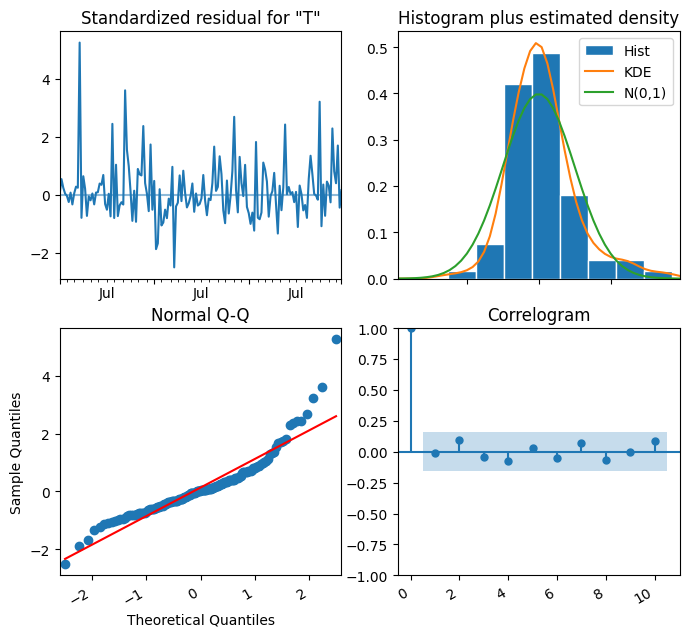

In [ ]:
# Display the model diagnostics
sarima_weekly_fig = sarima_weekly_results.plot_diagnostics(figsize=(8, 8))
sarima_weekly_fig.autofmt_xdate()
plt.show()

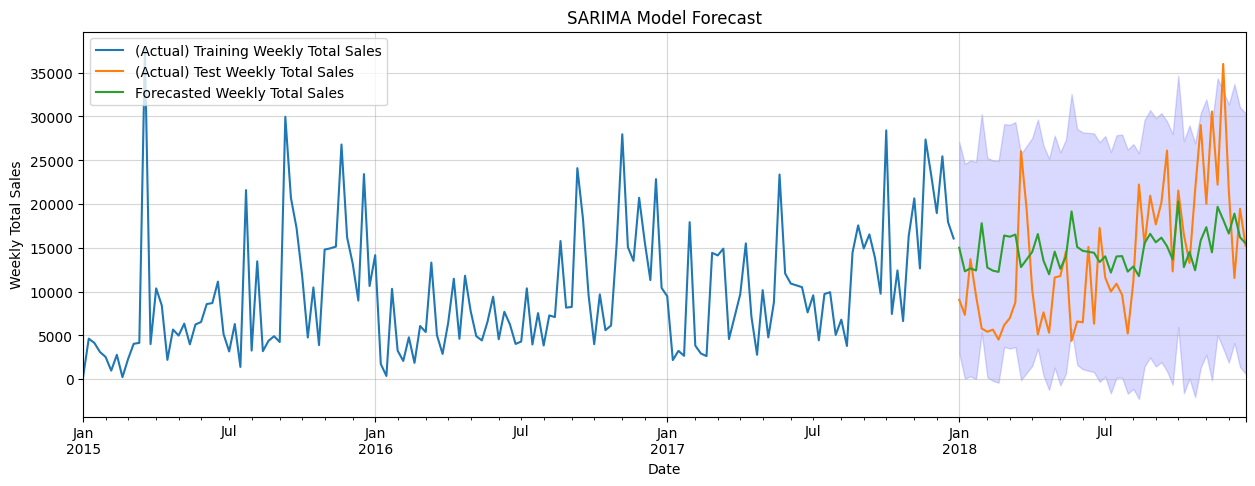

In [ ]:
# Get forecast and confidence intervals for two years
sarima_weekly_forecast = sarima_weekly_results.get_forecast(steps=52)
sarima_weekly_forecast_values = sarima_weekly_forecast.predicted_mean
weekly_confidence_intervals = sarima_weekly_forecast.conf_int()

# Plot forecast with training data
ax = sarima_weekly_df_train[-52*4:].plot(figsize=(15,5))
ax = sarima_weekly_df_test.plot(ax=ax)
sarima_weekly_forecast_values.plot()

plt.fill_between(sarima_weekly_forecast_values.index,
                 weekly_confidence_intervals['lower Total_Sales'],
                 weekly_confidence_intervals['upper Total_Sales'],
                 color='blue',
                 alpha=0.15)
plt.legend(['(Actual) Training Weekly Total Sales',
            '(Actual) Test Weekly Total Sales',
            'Forecasted Weekly Total Sales',],
           loc='upper left')
plt.xlabel('Date')
plt.ylabel('Weekly Total Sales')
plt.title('SARIMA Model Forecast')
plt.grid(alpha=0.5)
plt.show()

In [ ]:
# Predicted values and actual values
sarima_monthly_predicted_values = sarima_monthly_forecast_values.values
sarima_monthly_actual_values = sarima_monthly_df_test.values.flatten()

# Mean Absolute Error (MAE)
sarima_monthly_mae = np.mean(np.abs(sarima_monthly_predicted_values - sarima_monthly_actual_values))
print("SARIMA (Monthly) - MAE:", sarima_monthly_mae)

# Root Mean Squared Error (RMSE)
sarima_monthly_mse = np.mean((sarima_monthly_predicted_values - sarima_monthly_actual_values) ** 2)
sarima_monthly_rmse = np.sqrt(sarima_monthly_mse)

print("SARIMA (Monthly) - RMSE:", sarima_monthly_rmse)
# Mean Absolute Percentage Error (MAPE)
sarima_monthly_mape = np.mean(np.abs((sarima_monthly_predicted_values - sarima_monthly_actual_values) / sarima_monthly_actual_values)) * 100
print("SARIMA (Monthly) - MAPE:", sarima_monthly_mape)


SARIMA (Monthly) - MAE: 14399.079544609349
SARIMA (Monthly) - RMSE: 19332.20840635564
SARIMA (Monthly) - MAPE: 28.420425590059708


In [ ]:
# Predicted values and actual values
sarima_weekly_predicted_values = sarima_weekly_forecast_values.values
sarima_weekly_actual_values = sarima_weekly_df_test.values.flatten()

# Mean Absolute Error (MAE)
sarima_weekly_mae = np.mean(np.abs(sarima_weekly_predicted_values - sarima_weekly_actual_values))
print("SARIMA (Weekly) - MAE:", sarima_weekly_mae)

# Root Mean Squared Error (RMSE)
sarima_weekly_mse = np.mean((sarima_weekly_predicted_values - sarima_weekly_actual_values) ** 2)
sarima_weekly_rmse = np.sqrt(sarima_weekly_mse)

print("SARIMA (Weekly) - RMSE:", sarima_weekly_rmse)
# Mean Absolute Percentage Error (MAPE)
sarima_weekly_mape = np.mean(np.abs((sarima_weekly_predicted_values - sarima_weekly_actual_values) / sarima_weekly_actual_values)) * 100
print("SARIMA (Weekly) - MAPE:", sarima_weekly_mape)

SARIMA (Weekly) - MAE: 5952.1403490063685
SARIMA (Weekly) - RMSE: 7372.104237135961
SARIMA (Weekly) - MAPE: 63.693097283107505


# Facebook Prophet

$$
y(t) = g(t) + s(t) + h(t) +\epsilon_t
$$

* $g(t)$: Trend component
* $s(t)$: Seasonal component
* $h(t)$: Holidays or events component
* $\epsilon_t$: Error term

In [ ]:
monthly_total_sales = monthly_sales[['Date', 'Total_Sales']]
# monthly_total_sales = daily_total_sales.resample('M', on='Order Date').sum()
# monthly_total_sales.reset_index(inplace=True)
prophet_df = monthly_total_sales.rename(columns={'Date': 'ds', 'Total_Sales': 'y'})
prophet_df_training = prophet_df[prophet_df['ds'] <= '2017-12-31']
prophet_df_test = prophet_df[prophet_df['ds'] >= '2018-01-01']

In [ ]:
monthly_total_sales.head()

,Date,Total_Sales
0,2015-01-01,14205.707
1,2015-02-01,4519.892
2,2015-03-01,55205.797
3,2015-04-01,27906.855
4,2015-05-01,23644.303


In [ ]:
prophet_model = Prophet()
prophet_model.fit(prophet_df_training)
future = prophet_model.make_future_dataframe(periods=12, freq='M')

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


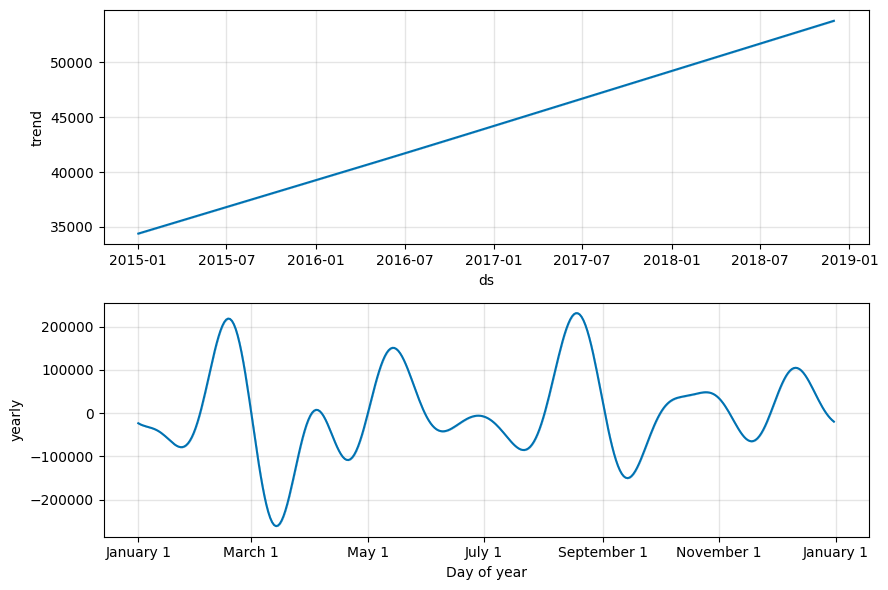

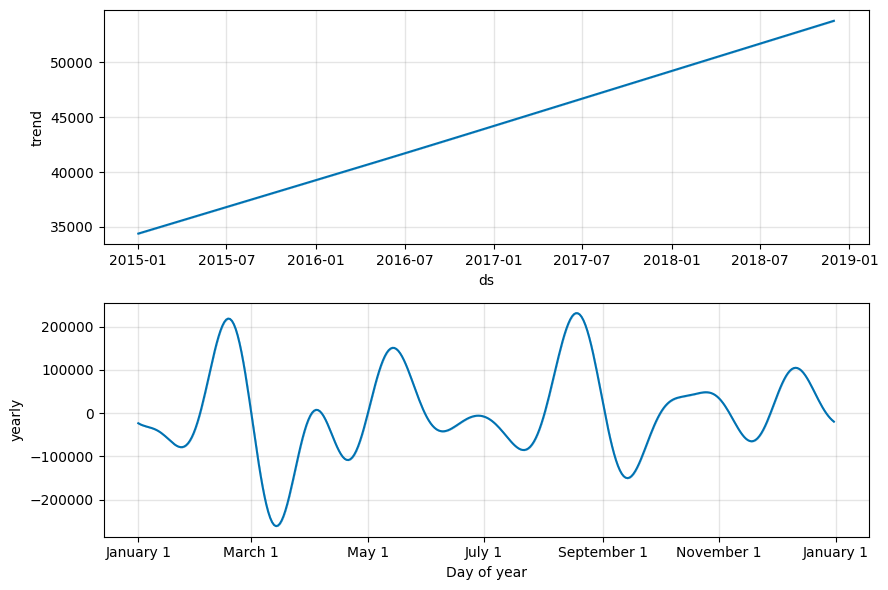

In [ ]:
forecast = prophet_model.predict(future)
prophet_model.plot_components(forecast)

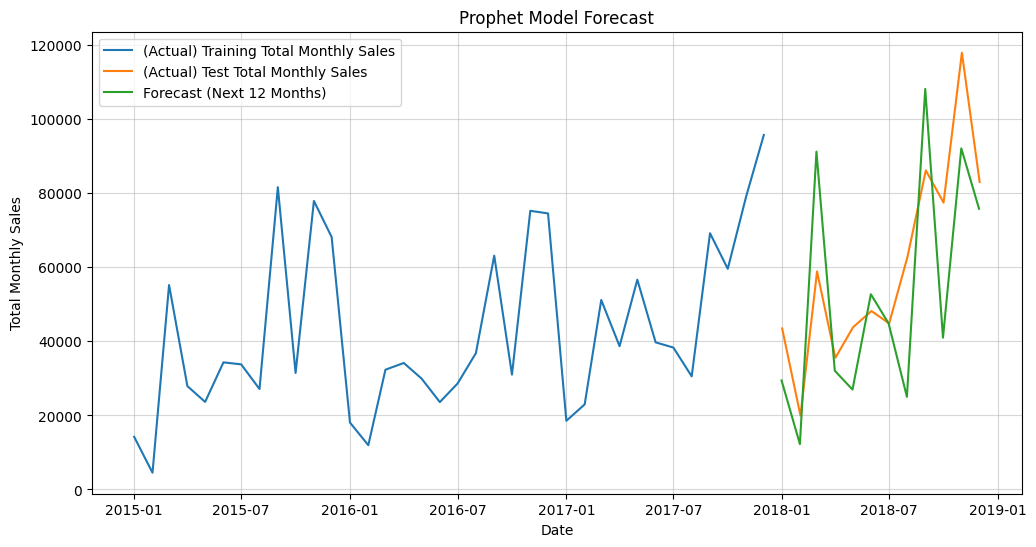

In [ ]:
# Make forecasts for the future
prophet_forecast = prophet_model.predict(future)

# Extract the actual data and forecast for the next 12 months
prophet_traing_value = prophet_df_training['y']
prophet_test_value = prophet_df_test['y']
prophet_forecast_value = prophet_forecast['yhat'][len(prophet_df_training):]

# # # Plot the actual data, fitted data, and forecast for the next 12 months
plt.figure(figsize=(12, 6))
plt.plot(prophet_df_training['ds'], prophet_traing_value, label='(Actual) Training Total Monthly Sales')
plt.plot(prophet_df_test['ds'], prophet_test_value, label='(Actual) Test Total Monthly Sales')
plt.plot(prophet_forecast['ds'][len(prophet_df_training):], prophet_forecast_value, label='Forecast (Next 12 Months)')

plt.legend()
plt.xlabel('Date')
plt.ylabel('Total Monthly Sales')
plt.title('Prophet Model Forecast')
plt.grid(alpha=0.5)
plt.show()

In [ ]:
# Predicted values and actual values
prophet_predicted_values = prophet_forecast_value
prophet_actual_values = prophet_test_value

# Mean Absolute Error (MAE)
mae = np.mean(np.abs(prophet_predicted_values - prophet_actual_values))
print("Prophet - MAE:", mae)

# Root Mean Squared Error (RMSE)
mse = np.mean((prophet_predicted_values - prophet_actual_values) ** 2)
rmse = np.sqrt(mse)

print("Prophet - RMSE:", rmse)
# Mean Absolute Percentage Error (MAPE)
mape = np.mean(np.abs((prophet_predicted_values - prophet_actual_values) / prophet_actual_values)) * 100
print("Prophet - MAPE:", mape)

Prophet - MAE: 17360.023930192117
Prophet - RMSE: 21571.073725349637
Prophet - MAPE: 28.912706927888404
